In [1]:
%load_ext lab_black

In [2]:
import tensorflow as tf
from tensorflow import keras
import warnings
import os

warnings.filterwarnings(action="ignore")

In [ ]:
"""
data = "/home/sharoonsaxena/Datasets/cats-vs-dogs.zip"
zip_ref = zipfile.ZipFile(data, "r")
zip_ref.extractall("/home/sharoonsaxena/Datasets/extracted/")
zip_ref.close()
"""

In [3]:
# the base address of the data folder
base_dir = "/home/sharoonsaxena/Datasets/extracted/cats-vs-dogs"

# Address of the training and validation folders
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")

# dogs and cat folders within training
train_dogs_dir = os.path.join(train_dir, "dogs")
train_cats_dir = os.path.join(train_dir, "cats")

# dogs and cats within validation folder
validation_dogs_dir = os.path.join(validation_dir, "dogs")
validation_cats_dir = os.path.join(validation_dir, "cats")

In [4]:
# finding out number od images in the respective directories
print("total training cat images :", len(os.listdir(train_cats_dir)))
print("total training dog images :", len(os.listdir(train_dogs_dir)))

print("total validation cat images :", len(os.listdir(validation_cats_dir)))
print("total validation dog images :", len(os.listdir(validation_dogs_dir)))

total training cat images : 12300
total training dog images : 12300
total validation cat images : 200
total validation dog images : 200


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# rescaling images
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
validation_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# input flow of training images
train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=2460, class_mode="binary", target_size=(150, 150)
)

# input flow from validation images
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, batch_size=200, class_mode="binary", target_size=(150, 150)
)

Found 24600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


#### Pre_trained_models in tensorflow can be downloaded on the fly using tf.keras.application.model_name
* Specify parameters to determine what exactly you are looking for

In [6]:
# Downloading pre-trained inceptionV3
pre_trained_model = tf.keras.applications.InceptionV3(
    input_shape=(150, 150, 3),  # The image shape this model should be expecting
    include_top=False,  # removes the classifier part of the model
    weights="imagenet",  # load the weights which were learned on imagenet
)

In [7]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [8]:
# freezing the feature layers of model so they cannot be trained any further
for layer in pre_trained_model.layers:
    layer.trainable = False

#### Since the final layer of features is too small, we are going to pick up a layer from middle which still has some substantial size **mixed7**

In [9]:
# fetching a layer from the pre_trained_model
last_layer = pre_trained_model.get_layer("mixed7")
print("Output shape of the last layer picked: ", last_layer.output_shape)

# storing the output_shape for future use
last_output = last_layer.output

Output shape of the last layer picked:  (None, 7, 7, 768)


Now that we have the last layer defined, we will append our own dense layer for the classification prediction.

In [10]:
from tensorflow.keras.optimizers import RMSprop

# Flattening the output of the last layer
x = keras.layers.Flatten()(last_output)

# adding a fully connected layer
x = keras.layers.Dense(units=1024, activation="relu")(x)

# Adding Dropout
x = keras.layers.Dropout(0.2)(x)

# adding output layer
output_layer = keras.layers.Dense(units=1, activation="sigmoid")(x)

now the pre_trained_model and the classification layers have been defined, we will append them together to form the final model.

In [11]:
final_model = keras.Model(
    pre_trained_model.input,  # inputs of instantiated pre_trained_model
    output_layer,  #  and classification layers
)

In [12]:
final_model.compile(
    optimizer=RMSprop(lr=0.001), loss="binary_crossentropy", metrics=["accuracy"]
)

In [13]:
history = final_model.fit(
    train_generator, validation_data=validation_generator, epochs=20
)

Epoch 1/20
10/10 [==============================] - 412s 41s/step - loss: 7.7542 - accuracy: 0.8017 - val_loss: 0.1475 - val_accuracy: 0.9350
Epoch 2/20
10/10 [==============================] - 417s 42s/step - loss: 0.1518 - accuracy: 0.9361 - val_loss: 0.0805 - val_accuracy: 0.9675
Epoch 3/20
10/10 [==============================] - 419s 42s/step - loss: 0.1197 - accuracy: 0.9483 - val_loss: 0.1354 - val_accuracy: 0.9375
Epoch 4/20
10/10 [==============================] - 417s 42s/step - loss: 0.3313 - accuracy: 0.8681 - val_loss: 0.3147 - val_accuracy: 0.8300
Epoch 5/20
10/10 [==============================] - 429s 43s/step - loss: 0.1248 - accuracy: 0.9446 - val_loss: 0.0879 - val_accuracy: 0.9625
Epoch 6/20
10/10 [==============================] - 439s 43s/step - loss: 0.1059 - accuracy: 0.9545 - val_loss: 0.0613 - val_accuracy: 0.9700
Epoch 7/20
10/10 [==============================] - 396s 39s/step - loss: 0.1000 - accuracy: 0.9570 - val_loss: 0.0921 - val_accuracy: 0.9575
Epoch 

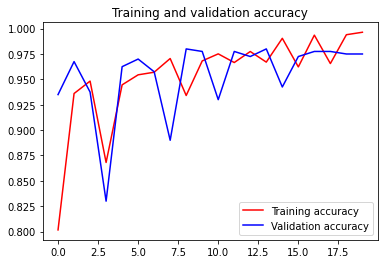

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.plot(epochs, acc, "r", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend(loc=0)
plt.figure()


plt.show()